In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time, pickle, json 
from glob import glob 
from PIL import Image
import cv2 
from typing import List, Tuple, Dict
from statistics import mean 
from tqdm import tqdm 
import torch 
import torch.nn as nn 
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


['gdrive/My Drive/maps/train/1056.jpg', 'gdrive/My Drive/maps/train/1021.jpg', 'gdrive/My Drive/maps/train/1028.jpg', 'gdrive/My Drive/maps/train/111.jpg', 'gdrive/My Drive/maps/train/145.jpg', 'gdrive/My Drive/maps/train/1049.jpg', 'gdrive/My Drive/maps/train/1066.jpg', 'gdrive/My Drive/maps/train/1004.jpg', 'gdrive/My Drive/maps/train/1045.jpg', 'gdrive/My Drive/maps/train/1039.jpg', 'gdrive/My Drive/maps/train/1008.jpg', 'gdrive/My Drive/maps/train/1042.jpg', 'gdrive/My Drive/maps/train/1024.jpg', 'gdrive/My Drive/maps/train/154.jpg', 'gdrive/My Drive/maps/train/1013.jpg', 'gdrive/My Drive/maps/train/1011.jpg', 'gdrive/My Drive/maps/train/1032.jpg', 'gdrive/My Drive/maps/train/1010.jpg', 'gdrive/My Drive/maps/train/157.jpg', 'gdrive/My Drive/maps/train/1033.jpg', 'gdrive/My Drive/maps/train/1079.jpg', 'gdrive/My Drive/maps/train/1007.jpg', 'gdrive/My Drive/maps/train/141.jpg', 'gdrive/My Drive/maps/train/1077.jpg', 'gdrive/My Drive/maps/train/125.jpg', 'gdrive/My Drive/maps/train/10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


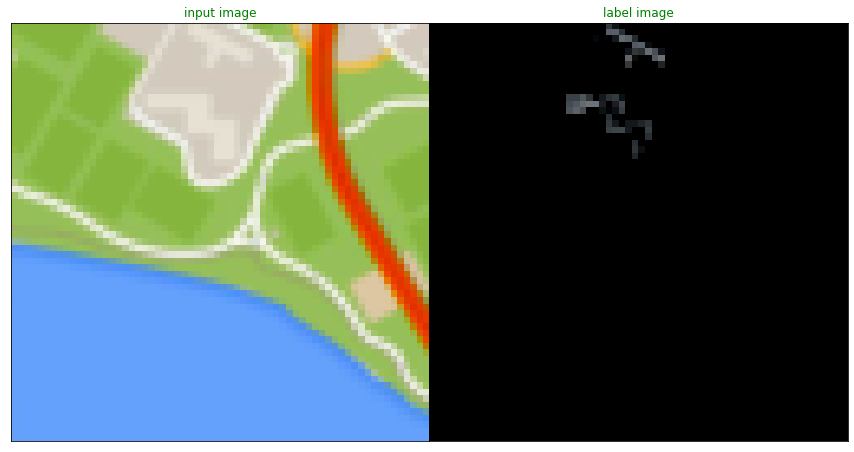

In [2]:
MEAN = (0.5, 0.5, 0.5,)
STD = (0.5, 0.5, 0.5,)
RESIZE = 64

def read_path(filepath):
    root_path="gdrive/My Drive/maps/"
    path=os.path.join(root_path, filepath)
    dataset= []
    for p in glob(path+"/"+"*.jpg"):
        dataset.append(p)
    print(dataset)
    return dataset 

class Transform():
    def __init__(self, resize=RESIZE, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([
            transforms.Resize((resize, resize)), 
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)

class Dataset(object):
    def __init__(self, files):
        self.files=files 
        self.trasformer=Transform()
        
    def _separate(self, img):
        img = np.array(img)
        h, w, _ = img.shape
        w = int(w/2)
        return Image.fromarray(img[:, w:, :]), Image.fromarray(img[:, :w, :])
    
    def __getitem__(self,idx) :
        img=Image.open(self.files[idx])
        input, output = self._separate(img)
        input_tensor = self.trasformer(input)
        output_tensor = self.trasformer(output)
        return input_tensor, output_tensor 
    
    def __len__(self):
        return len(self.files)
    
def show_img_sample(img, img1):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    ax = axes.ravel()
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("input image", c="g")
    ax[1].imshow(img1.permute(1, 2, 0))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("label image", c="g")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
        
train = read_path("train")
val = read_path("val")
train_ds = Dataset(train)
val_ds = Dataset(val)
show_img_sample(train_ds.__getitem__(1)[0], train_ds.__getitem__(1)[1])

In [3]:
BATCH_SIZE = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc1 = self.conv2Relu(3, 32, 5)
        self.enc2 = self.conv2Relu(32, 64, pool_size=4)
        self.enc3 = self.conv2Relu(64, 128, pool_size=2)
        self.enc4 = self.conv2Relu(128, 256, pool_size=2)
        
        self.dec1 = self.deconv2Relu(256, 128, pool_size=2)
        self.dec2 = self.deconv2Relu(128+128, 64, pool_size=2)
        self.dec3 = self.deconv2Relu(64+64, 32, pool_size=4)
        self.dec4 = nn.Sequential(
            nn.Conv2d(32+32, 3, 5, padding=2), 
            nn.Tanh()
        )
        
    def conv2Relu(self, in_c, out_c, kernel_size=3, pool_size=None):
        layer = []
        if pool_size:
            # Down width and height
            layer.append(nn.AvgPool2d(pool_size))
        # Up channel size 
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, padding=(kernel_size-1)//2))
        layer.append(nn.LeakyReLU(0.2, inplace=True))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)
    
    def deconv2Relu(self, in_c, out_c, kernel_size=3, stride=1, pool_size=None):
        layer = []
        if pool_size:
            # Up width and height
            layer.append(nn.UpsamplingNearest2d(scale_factor=pool_size))
        # Down channel size 
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, stride, padding=1))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)
    
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3) # (b, 256, 4, 4)
        
        out = self.dec1(x4)
        out = self.dec2(torch.cat((out, x3), dim=1)) # concat channel 
        out = self.dec3(torch.cat((out, x2), dim=1))
        out = self.dec4(torch.cat((out, x1), dim=1)) # (b, 3, 64, 64)
        return out 

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = self.conv2relu(6, 16, 5, cnt=1)
        self.layer2 = self.conv2relu(16, 32, pool_size=4)
        self.layer3 = self.conv2relu(32, 64, pool_size=2)
        self.layer4 = self.conv2relu(64, 128, pool_size=2)
        self.layer5 = self.conv2relu(128, 256, pool_size=2)
        self.layer6 = nn.Conv2d(256, 1, kernel_size=1)
        
    def conv2relu(self, in_c, out_c, kernel_size=3, pool_size=None, cnt=2):
        layer = []
        for i in range(cnt):
            if i == 0 and pool_size != None:
                # Down width and height 
                layer.append(nn.AvgPool2d(pool_size))
            # Down channel size 
            layer.append(nn.Conv2d(in_c if i == 0 else out_c, 
                                   out_c,
                                   kernel_size,
                                   padding=(kernel_size-1)//2))
            layer.append(nn.BatchNorm2d(out_c))
            layer.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layer)
        
    def forward(self, x, x1):
        x = torch.cat((x, x1), dim=1)
        out = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        return self.layer6(out)

In [6]:
def train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d):
    G.train()
    D.train()
    LAMBDA = 100.0
    total_loss_g, total_loss_d = [], []
    for i,(input_img,real_img) in enumerate(tqdm(train_dl)):
        input_img = input_img    
        real_img = real_img
        real_label = torch.ones(input_img.size()[0], 1, 2, 2)
        fake_label = torch.zeros(input_img.size()[0], 1, 2, 2)
        # Generator 
        fake_img = G(input_img)
        fake_img_ = fake_img.detach() # commonly using 
        out_fake = D(fake_img, input_img)
        loss_g_bce = criterion_bce(out_fake, real_label) # binaryCrossEntropy
        loss_g_mae = criterion_mae(fake_img, real_img) # MSELoss
        loss_g = loss_g_bce + LAMBDA * loss_g_mae 
        total_loss_g.append(loss_g.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        # Discriminator
        out_real = D(real_img, input_img)
        loss_d_real = criterion_bce(out_real, real_label)
        out_fake = D(fake_img_, input_img)
        loss_d_fake = criterion_bce(out_fake, fake_label)
        loss_d = loss_d_real + loss_d_fake 
        total_loss_d.append(loss_d.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
    return mean(total_loss_g), mean(total_loss_d), fake_img.detach().cpu() 

        
def show_losses(g, d):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    ax = axes.ravel()
    ax[0].plot(np.arange(len(g)).tolist(), g)
    ax[0].set_title("Generator Loss")
    ax[1].plot(np.arange(len(d)).tolist(), d)
    ax[1].set_title("Discriminator Loss")
    plt.show()


def train_loop(train_dl, G, D, num_epoch, lr=0.0002, betas=(0.5, 0.999)):
    optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
    optimizer_d = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)
    criterion_mae = nn.L1Loss()
    criterion_bce = nn.BCEWithLogitsLoss()
    total_loss_d, total_loss_g = [], []
    result = {}
    for e in range(num_epoch):
        loss_g, loss_d, fake_img = train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d)
        total_loss_d.append(loss_d)
        total_loss_g.append(loss_g)
        result["G"] = total_loss_d 
        result["D"] = total_loss_g 
        print(e)
    show_losses(total_loss_g, total_loss_d)

    
    return G, D


100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


0


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


1


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


2


100%|██████████| 68/68 [01:32<00:00,  1.37s/it]


3


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


4


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


5


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


6


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


7


100%|██████████| 68/68 [01:34<00:00,  1.40s/it]


8


100%|██████████| 68/68 [01:33<00:00,  1.38s/it]


9


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


10


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


11


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


12


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


13


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


14


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


15


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


16


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


17


100%|██████████| 68/68 [01:33<00:00,  1.38s/it]


18


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


19


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


20


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


21


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


22


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


23


100%|██████████| 68/68 [01:34<00:00,  1.40s/it]


24


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


25


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


26


100%|██████████| 68/68 [01:34<00:00,  1.38s/it]


27


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


28


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


29


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


30


100%|██████████| 68/68 [01:34<00:00,  1.38s/it]


31


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


32


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


33


100%|██████████| 68/68 [01:33<00:00,  1.38s/it]


34


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


35


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


36


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


37


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


38


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


39


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


40


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


41


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


42


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


43


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


44


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


45


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


46


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


47


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


48


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


49


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


50


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


51


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


52


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


53


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


54


100%|██████████| 68/68 [01:34<00:00,  1.38s/it]


55


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


56


100%|██████████| 68/68 [01:34<00:00,  1.38s/it]


57


100%|██████████| 68/68 [01:32<00:00,  1.37s/it]


58


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


59


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


60


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


61


100%|██████████| 68/68 [01:34<00:00,  1.40s/it]


62


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


63


100%|██████████| 68/68 [01:32<00:00,  1.37s/it]


64


100%|██████████| 68/68 [01:32<00:00,  1.36s/it]


65


100%|██████████| 68/68 [01:32<00:00,  1.36s/it]


66


100%|██████████| 68/68 [01:32<00:00,  1.36s/it]


67


100%|██████████| 68/68 [01:33<00:00,  1.38s/it]


68


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


69


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


70


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


71


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


72


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


73


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


74


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


75


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


76


100%|██████████| 68/68 [01:33<00:00,  1.38s/it]


77


100%|██████████| 68/68 [01:34<00:00,  1.40s/it]


78


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


79


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


80


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


81


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


82


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


83


100%|██████████| 68/68 [01:32<00:00,  1.36s/it]


84


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


85


100%|██████████| 68/68 [01:32<00:00,  1.37s/it]


86


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


87


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


88


100%|██████████| 68/68 [01:34<00:00,  1.40s/it]


89


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


90


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


91


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


92


100%|██████████| 68/68 [01:32<00:00,  1.37s/it]


93


100%|██████████| 68/68 [01:32<00:00,  1.37s/it]


94


100%|██████████| 68/68 [01:36<00:00,  1.43s/it]


95


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


96


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


97


100%|██████████| 68/68 [01:33<00:00,  1.38s/it]


98


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


99


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


100


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


101


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


102


100%|██████████| 68/68 [01:33<00:00,  1.38s/it]


103


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


104


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


105


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


106


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


107


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


108


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


109


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


110


100%|██████████| 68/68 [01:38<00:00,  1.44s/it]


111


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


112


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


113


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


114


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


115


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


116


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


117


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


118


100%|██████████| 68/68 [01:38<00:00,  1.44s/it]


119


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


120


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


121


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


122


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


123


100%|██████████| 68/68 [01:38<00:00,  1.44s/it]


124


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


125


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


126


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]


127


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


128


100%|██████████| 68/68 [01:40<00:00,  1.47s/it]


129


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


130


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


131


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


132


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


133


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


134


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


135


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


136


100%|██████████| 68/68 [01:40<00:00,  1.47s/it]


137


100%|██████████| 68/68 [01:40<00:00,  1.47s/it]


138


100%|██████████| 68/68 [01:40<00:00,  1.47s/it]


139


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


140


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


141


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


142


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


143


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


144


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


145


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


146


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


147


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


148


100%|██████████| 68/68 [01:37<00:00,  1.43s/it]


149


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


150


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


151


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


152


100%|██████████| 68/68 [01:38<00:00,  1.44s/it]


153


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


154


100%|██████████| 68/68 [01:38<00:00,  1.44s/it]


155


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


156


100%|██████████| 68/68 [01:40<00:00,  1.47s/it]


157


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


158


100%|██████████| 68/68 [01:38<00:00,  1.46s/it]


159


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


160


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


161


100%|██████████| 68/68 [01:42<00:00,  1.50s/it]


162


100%|██████████| 68/68 [01:42<00:00,  1.51s/it]


163


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


164


100%|██████████| 68/68 [01:41<00:00,  1.49s/it]


165


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


166


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


167


100%|██████████| 68/68 [01:41<00:00,  1.49s/it]


168


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


169


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


170


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


171


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


172


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


173


100%|██████████| 68/68 [01:38<00:00,  1.44s/it]


174


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


175


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


176


100%|██████████| 68/68 [01:42<00:00,  1.51s/it]


177


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


178


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


179


100%|██████████| 68/68 [01:40<00:00,  1.47s/it]


180


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


181


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


182


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


183


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


184


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


185


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


186


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


187


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


188


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]


189


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


190


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


191


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


192


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


193


100%|██████████| 68/68 [01:40<00:00,  1.47s/it]


194


100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


195


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]


196


100%|██████████| 68/68 [01:40<00:00,  1.47s/it]


197


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]


198


100%|██████████| 68/68 [01:40<00:00,  1.48s/it]


199


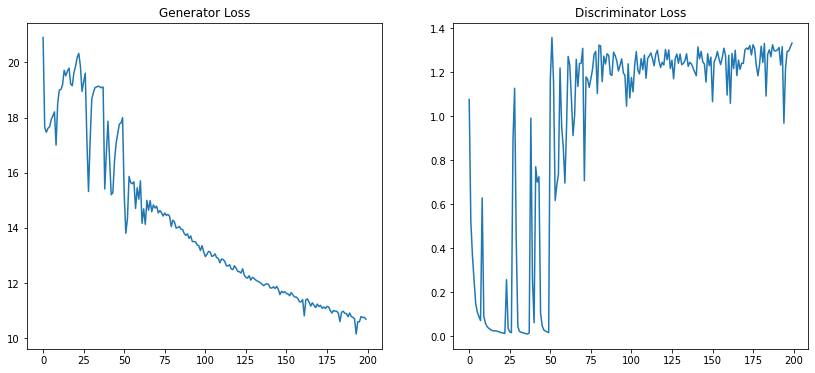

In [7]:
G = Generator()
D = Discriminator()
EPOCH = 200
trained_G, trained_D = train_loop(train_dl, G, D, EPOCH)

In [10]:
def de_norm(img):
    img_ = img.mul(torch.FloatTensor(STD).view(3, 1, 1))
    img_ = img_.add(torch.FloatTensor(MEAN).view(3, 1, 1)).detach().numpy()
    img_ = np.transpose(img_, (1, 2, 0))
    return img_ 
def evaluate(val_dl, G):
    with torch.no_grad():
        fig, axes = plt.subplots(3, 4, figsize=(12, 12))
        ax = axes.ravel()
        for input_img, real_img in tqdm(val_dl):
            input_img = input_img
            real_img = real_img
            fake_img = G(input_img)
            ax[0].set_ylabel("Input Image", c="g")
            ax[4].set_ylabel("Real Image", c="g")
            ax[8].set_ylabel("Generated Image", c="r")
            a=0
            s=0
            d=0
            for i in range(4):
                ax[i].imshow(input_img[a].permute(1, 2, 0))
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                a=a+1
            for i in range(4,8):
                ax[i].imshow(de_norm(real_img[s]))
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                s=s+1
            for i in range(8,12):
                ax[i].imshow(de_norm(fake_img[d]))
                d=d+1
                ax[i].set_xticks([])
                ax[i].set_yticks([])
        

  3%|▎         | 2/70 [00:01<00:53,  1.26it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  4%|▍         | 3/70 [00:02<00:52,  1.27it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  6%|▌         | 4/70 [00:03<00:52,  1.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 14%|█▍        | 10/70 [00:07<00:47,  1.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for im

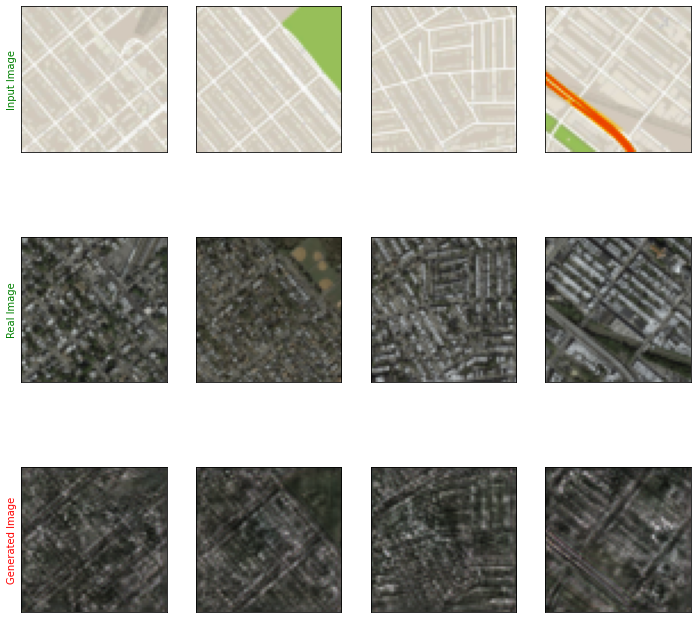

In [11]:
evaluate(val_dl,G)